In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import os
from torch import nn
import copy
import matplotlib.pyplot as plt

from torch import optim
from torch.utils.data import random_split

import torch.nn.utils as utils
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [4]:
## Write the model here later 

class BaseModel(nn.Module):
    def __init__(self, input_dim1=4, input_dim2=1, hidden_dim=128, output_dim=2):
        super(BaseModel, self).__init__()
        # For the first input
        self.fc1 = nn.Linear(input_dim1, hidden_dim)
        # For the second input
        self.fc2 = nn.Linear(input_dim2, hidden_dim)
        # Combined layers
        self.fc_combined = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc_combined_2 = nn.Linear(hidden_dim, hidden_dim//2)
    
        self.out = nn.Linear(hidden_dim//2, output_dim)

    def forward(self, initial_state, action):

        original_initial_state = initial_state.clone()
        action_original = action.clone()
        batch_size = original_initial_state.shape[0]
        initial_state_processed, actions_processed = self.input_processing(initial_state,action_original)
    
        h1 = F.gelu(self.fc1(initial_state_processed))
        h2 = F.gelu(self.fc2(actions_processed))
        h = torch.cat([h1, h2], dim=1)
        h = F.gelu(self.fc_combined(h))
        h = F.gelu(self.fc_combined_2(h))
        
        out = self.out(h)

        original_voltage = original_initial_state[:,1]
        original_temperature = original_initial_state[:,2]

        final_voltage = original_voltage + out[:,0]
        final_temperature = original_temperature + out[:,1]

        final_output = torch.stack([final_voltage,final_temperature], dim=1)
        return final_output
    
    
    def input_processing(self,initial_state, action):
       
        #print(initial_state.shape,action.shape,"Inputs shape")
        original_initial_state = initial_state.clone() #So that original value does not change
        original_initial_state[:,0] = original_initial_state[:,0]*10 ## Normalization for resistance
        original_initial_state[:,1] = original_initial_state[:,1]/3 #Voltage Normalization
        original_initial_state[:,2] = original_initial_state[:,2]/30 #Temperature Normalization

        original_actions = action.clone() #So that original value does not change

        original_actions = original_actions/5 #Current Normalization
       
        return original_initial_state, original_actions




In [5]:

class DeepEnsemble(nn.Module):
    def __init__(self, num_models=10, input_dim1=4, input_dim2=1, hidden_dim=128, output_dim=2):
        super(DeepEnsemble, self).__init__()
        self.models = nn.ModuleList([
            BaseModel(input_dim1, input_dim2, hidden_dim, output_dim) 
            for _ in range(num_models)
        ])

    def forward(self, initial_state, action, 
                return_variance=False, return_individual=False):
        outputs = [model(initial_state, action) for model in self.models]
        outputs = torch.stack(outputs, dim=0)  # [num_models, batch, output_dim]

        # mean_pred = outputs.mean(dim=0)  # [batch, output_dim]
        # var_pred = outputs.var(dim=0)    # [batch, output_dim]

        # results = {"mean": mean_pred,""}
        # if return_variance:
        #     results["variance"] = var_pred
        # if return_individual:
        #     results["individual"] = outputs  # [num_models, batch, output_dim]

        return outputs


In [6]:
path= '../../Capacity_prediction/Log_files/Log_files/cell_log_age_2s_P065_1_S01_C03.csv'
df = pd.read_csv(path,sep=';')
df.head(10)

,timestamp_s,v_raw_V,ocv_est_V,i_raw_A,t_cell_degC,soc_est,delta_q_Ah,EFC,cap_aged_est_Ah,R0_mOhm,R1_mOhm
0,5700,3.5516,3.5521,0.0008,24.99,26.51,0.0,0.0,NaN,NaN,NaN
1,5702,3.5521,3.5521,-0.0003,24.99,26.51,0.0,0.0,NaN,NaN,NaN
2,5704,3.5520,3.5521,0.0004,24.99,26.51,0.0,0.0,NaN,NaN,NaN
3,5706,3.5522,3.5521,0.0001,24.99,26.51,0.0,0.0,NaN,NaN,NaN
4,5708,3.5523,3.5521,0.0008,24.98,26.51,0.0,0.0,NaN,NaN,NaN
5,5710,3.5517,3.5521,-0.0010,24.99,26.51,0.0,0.0,NaN,NaN,NaN
6,5712,3.5523,3.5521,-0.0003,24.98,26.51,0.0,0.0,NaN,NaN,NaN
7,5714,3.5521,3.5521,0.0001,24.98,26.51,0.0,0.0,NaN,NaN,NaN
8,5716,3.5523,3.5521,0.0004,24.99,26.51,0.0,0.0,NaN,NaN,NaN
9,5718,3.5524,3.5521,0.0011,24.98,26.51,0.0,0.0,NaN,NaN,NaN


In [7]:
df

,timestamp_s,v_raw_V,ocv_est_V,i_raw_A,t_cell_degC,soc_est,delta_q_Ah,EFC,cap_aged_est_Ah,R0_mOhm,R1_mOhm
0,5700,3.5516,3.5521,0.0008,24.99,26.51,0.0000,0.000,NaN,NaN,NaN
1,5702,3.5521,3.5521,-0.0003,24.99,26.51,0.0000,0.000,NaN,NaN,NaN
2,5704,3.5520,3.5521,0.0004,24.99,26.51,0.0000,0.000,NaN,NaN,NaN
3,5706,3.5522,3.5521,0.0001,24.99,26.51,0.0000,0.000,NaN,NaN,NaN
4,5708,3.5523,3.5521,0.0008,24.98,26.51,0.0000,0.000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15131418,30268536,4.0728,4.0731,-0.0001,2.04,85.21,2.5728,761.967,NaN,NaN,NaN
15131419,30268538,4.0726,4.0731,0.0005,2.04,85.20,2.5728,761.967,NaN,NaN,NaN
15131420,30268540,4.0733,4.0731,0.0012,2.04,85.21,2.5728,761.967,NaN,NaN,NaN
15131421,30268542,4.0730,4.0731,0.0005,2.04,85.21,2.5728,761.967,NaN,NaN,NaN


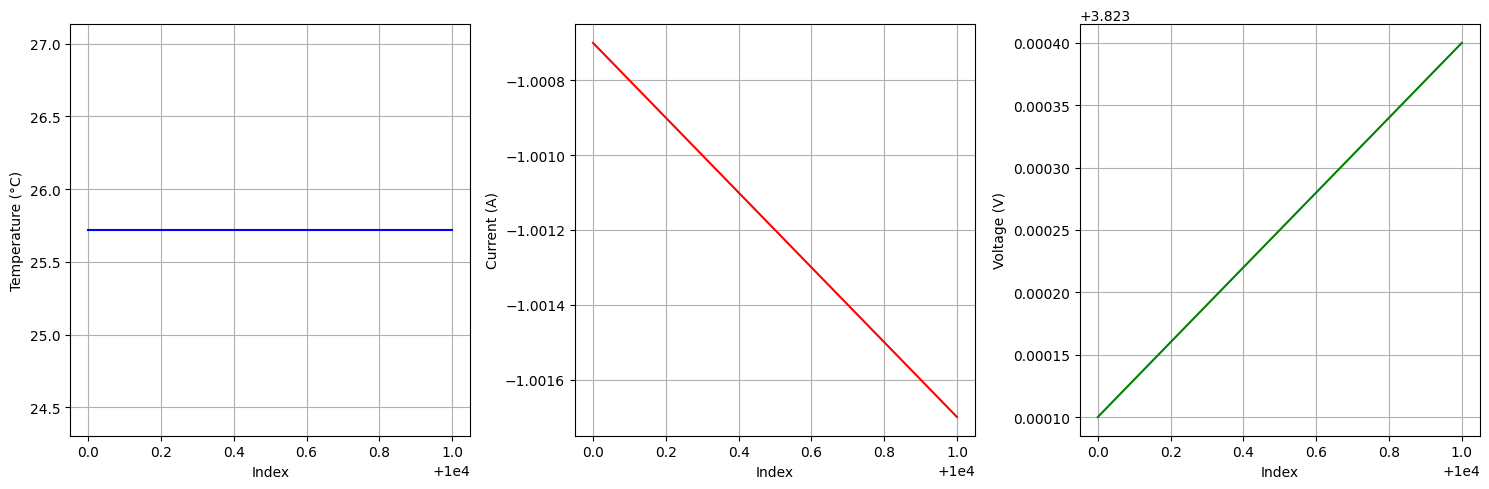

In [8]:
# Create figure with three subplots arranged horizontally (1 row, 3 columns)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# Define the range
start = 10000
ending = start+2

# First subplot (t_cell_degC)
ax1.plot(df['t_cell_degC'][start:ending], color='blue')
ax1.set_title('')  # Empty title
ax1.set_xlabel('Index')
ax1.set_ylabel('Temperature (°C)')
ax1.grid(True)

# Second subplot (i_raw_A)
ax2.plot(df['i_raw_A'][start:ending], color='red')
ax2.set_title('')  # Empty title
ax2.set_xlabel('Index')
ax2.set_ylabel('Current (A)')
ax2.grid(True)

# Third subplot (v_raw_V)
ax3.plot(df['v_raw_V'][start:ending], color='green')
ax3.set_title('')  # Empty title
ax3.set_xlabel('Index')
ax3.set_ylabel('Voltage (V)')
ax3.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
# Create relative_age column with linear interpolation from 0 to 1
df['relative_age'] = np.linspace(0, 1, len(df))

In [10]:
# Step 1: Calculate delV and delI
df['delV'] = df['v_raw_V'].diff()
df['delI'] = df['i_raw_A'].diff()

# Replace exact 0 in delI with NaN
df.loc[df['delI'] == 0, 'delI'] = np.nan

# Step 2: Calculate delV/delI
df['delV_delI'] = df['delV'] / df['delI']

# Step 3: Fill delV/delI for rows where delI was NaN with previous non-NaN
df['delV_delI'] = df['delV_delI'].fillna(method='ffill')

# Step 4: Backfill first row's NaN (since diff creates NaN in first row)
df['delV_delI'] = df['delV_delI'].fillna(method='bfill')


/tmp/ipykernel_61376/781649033.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['delV_delI'] = df['delV_delI'].fillna(method='ffill')
/tmp/ipykernel_61376/781649033.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['delV_delI'] = df['delV_delI'].fillna(method='bfill')


In [11]:
df

,timestamp_s,v_raw_V,ocv_est_V,i_raw_A,t_cell_degC,soc_est,delta_q_Ah,EFC,cap_aged_est_Ah,R0_mOhm,R1_mOhm,relative_age,delV,delI,delV_delI
0,5700,3.5516,3.5521,0.0008,24.99,26.51,0.0000,0.000,NaN,NaN,NaN,0.000000e+00,NaN,NaN,-0.454545
1,5702,3.5521,3.5521,-0.0003,24.99,26.51,0.0000,0.000,NaN,NaN,NaN,6.608764e-08,0.0005,-0.0011,-0.454545
2,5704,3.5520,3.5521,0.0004,24.99,26.51,0.0000,0.000,NaN,NaN,NaN,1.321753e-07,-0.0001,0.0007,-0.142857
3,5706,3.5522,3.5521,0.0001,24.99,26.51,0.0000,0.000,NaN,NaN,NaN,1.982629e-07,0.0002,-0.0003,-0.666667
4,5708,3.5523,3.5521,0.0008,24.98,26.51,0.0000,0.000,NaN,NaN,NaN,2.643506e-07,0.0001,0.0007,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15131418,30268536,4.0728,4.0731,-0.0001,2.04,85.21,2.5728,761.967,NaN,NaN,NaN,9.999997e-01,-0.0001,-0.0006,0.166667
15131419,30268538,4.0726,4.0731,0.0005,2.04,85.20,2.5728,761.967,NaN,NaN,NaN,9.999998e-01,-0.0002,0.0006,-0.333333
15131420,30268540,4.0733,4.0731,0.0012,2.04,85.21,2.5728,761.967,NaN,NaN,NaN,9.999999e-01,0.0007,0.0007,1.000000
15131421,30268542,4.0730,4.0731,0.0005,2.04,85.21,2.5728,761.967,NaN,NaN,NaN,9.999999e-01,-0.0003,-0.0007,0.428571


In [12]:

class BatteryDataset_Optimised(Dataset):
    def __init__(self, dataset=df.copy(), sequence_length = 2, prediction_length = 150):
        self.dataset = dataset
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.number_sequences = len(self.dataset)-self.sequence_length-10


    def __len__(self):
        return self.number_sequences

    def __getitem__(self, idx):
        i = idx
        chunk = self.dataset.iloc[i:i+self.sequence_length]
        
        # Initial state for this sequence
        init_state_2 = torch.tensor([[
            chunk.iloc[0].relative_age,## Relative age at t=0
            chunk.iloc[0].v_raw_V, ## voltage at t =0 
            chunk.iloc[0].t_cell_degC, ## temperature at t =0 
            chunk.iloc[0].i_raw_A ### current at t=0,
        ]], dtype=torch.float32, device='cuda')

        current = torch.tensor([[
            chunk.iloc[1].i_raw_A ### current at t=2s,
        ]], dtype=torch.float32, device='cuda')

        future_state = torch.tensor([[
            chunk.iloc[1].v_raw_V, ## voltage at t =0 
            chunk.iloc[1].t_cell_degC, ## temperature at t =0 
            ]], dtype=torch.float32, device='cuda')
          
        return init_state_2.squeeze(dim=0), current.squeeze(dim=0), future_state.squeeze(dim=0)

# Create dataset
dataset_opt = BatteryDataset_Optimised(dataset=df.copy())

# Create DataLoader
loader = DataLoader(dataset_opt, batch_size=64, shuffle=True)

# Example: fetch one batch
for batch_states, batch_currents, batch_vt in loader:
    print("states:", batch_states.shape)   
    print("currents:", batch_currents.shape) 
    print("voltage+temp:", batch_vt.shape)  
    break


states: torch.Size([64, 4])
currents: torch.Size([64, 1])
voltage+temp: torch.Size([64, 2])


In [13]:
from torch.utils.data import Subset

train_indices = []
val_indices = []
test_indices = []

dataset_selected = dataset_opt
n = len(dataset_selected)
block_size = 500

for i in range(0, n, block_size):
    block = list(range(i, min(i + block_size, n)))
    # Training: first 300
    train_indices.extend(block[:300])
    # Validation: next 100 (300-399)
    val_indices.extend(block[300:400])
    # Testing: next 100 (400-499)
    test_indices.extend(block[400:500])

train_set = Subset(dataset_selected, train_indices)
val_set = Subset(dataset_selected, val_indices)
test_set = Subset(dataset_selected, test_indices)


In [14]:
batch_size_ = 32*5*10
train_loader = DataLoader(train_set, batch_size=batch_size_, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size_, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size_, shuffle=False)


In [15]:
# Create ensemble
ensemble = DeepEnsemble(num_models=10).to("cuda").float()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = "digital_twin_simpler.pt"

checkpoint = torch.load(checkpoint_path, map_location=device)

# If the checkpoint contains 'state_dict'
if "state_dict" in checkpoint:
    ensemble.load_state_dict(checkpoint["state_dict"])
else:
    ensemble.load_state_dict(checkpoint)

ensemble.eval()  # set to eval mode
print("Model loaded successfully on", device)


Model loaded successfully on cuda


In [16]:
len(val_set)

3026300

In [17]:
# Keep only models 0–5
ensemble.models = nn.ModuleList(list(ensemble.models[:6]))


In [18]:
ensemble.models[0]

BaseModel(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=1, out_features=128, bias=True)
  (fc_combined): Linear(in_features=256, out_features=128, bias=True)
  (fc_combined_2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
)

In [19]:
# Horizon
H = 75  

# Starting index
idx = 3000*25

# --- Get the original tensors from your dataset ---
init_state, current, future_state = val_set[idx]  
print("init_state:", init_state)   # [4]
print("current:", current.shape)         # [1]
print("future_state (single):", future_state.shape)  # [2]

# --- Now build horizon manually ---
future_states, future_currents = [], []

for h in range(1, H+1):   # iterate idx+1 to idx+H
    future_state_tensor, cur_future, _ = val_set[idx + h]
    future_states.append(future_state_tensor)     # voltage + temp
    future_currents.append(cur_future)   # current

future_states = torch.stack(future_states)     # [H, 2]
future_currents = torch.stack(future_currents) # [H, 1]

print("future_states:", future_states.shape)
print("future_currents:", future_currents.shape)

all_future_time_stamps = []
for h in range(0, H):  
    future_state_tensor, cur_future, _ = val_set[idx + h]
    future_state_tensor = future_state_tensor.to(device).unsqueeze(0)#.float()       
    cur_future = cur_future.to(device).unsqueeze(0)#.float()
    #print(future_state_tensor, cur_future.shape,"SHAPE OF THE STATES with batchsize 1")
    #print(jd)
    ensemble_predictions = []
    for model_idx, (model) in enumerate(zip(ensemble.models)):
        if(h==0): ## The beginning states
            outputs = model[0](future_state_tensor, -1*cur_future)
            ensemble_predictions.append(outputs)
        else:  ## We take the pas predictions 
            current_state_predictions =  all_future_time_stamps[-1][model_idx]
            
            # print("$$$$$$$$$$$$$$$$$$$$$$$$$$")
            # print(current_state_predictions," The SHAPE --> ",current_state_predictions.shape)
            # print("$$$$$$$$$$$$$$$$$$$$$$$$$$")
            # print(future_state_tensor," The SHAPE --> ",future_state_tensor.shape)
            # print("*****************************")
            future_state_tensor[:,1:3] =  current_state_predictions[0]
            # print(future_state_tensor,"FUTURE STATE TENSOR IS CHANGED")
            # print(jd)
            outputs  =  model[0](future_state_tensor,-1*cur_future)
            ensemble_predictions.append(outputs)
            #print(jd)
            #pass
            

    #print(ensemble_predictions)
    all_future_time_stamps.append(ensemble_predictions)
    #print(all_future_time_stamps)
    
    #pass


init_state: tensor([ 2.4803e-02,  4.1559e+00,  3.4600e+00, -8.0000e-04], device='cuda:0')
current: torch.Size([1])
future_state (single): torch.Size([2])
future_states: torch.Size([75, 4])
future_currents: torch.Size([75, 1])


In [20]:
all_future_time_stamps

[[tensor([[4.1545, 3.4601]], device='cuda:0', grad_fn=<StackBackward0>),
  tensor([[4.1580, 3.4604]], device='cuda:0', grad_fn=<StackBackward0>),
  tensor([[4.1573, 3.4597]], device='cuda:0', grad_fn=<StackBackward0>),
  tensor([[4.1544, 3.4601]], device='cuda:0', grad_fn=<StackBackward0>),
  tensor([[4.1575, 3.4592]], device='cuda:0', grad_fn=<StackBackward0>),
  tensor([[4.1554, 3.4606]], device='cuda:0', grad_fn=<StackBackward0>)],
 [tensor([[4.1531, 3.4603]], device='cuda:0', grad_fn=<StackBackward0>),
  tensor([[4.1601, 3.4608]], device='cuda:0', grad_fn=<StackBackward0>),
  tensor([[4.1588, 3.4594]], device='cuda:0', grad_fn=<StackBackward0>),
  tensor([[4.1529, 3.4601]], device='cuda:0', grad_fn=<StackBackward0>),
  tensor([[4.1591, 3.4583]], device='cuda:0', grad_fn=<StackBackward0>),
  tensor([[4.1550, 3.4612]], device='cuda:0', grad_fn=<StackBackward0>)],
 [tensor([[4.1517, 3.4604]], device='cuda:0', grad_fn=<StackBackward0>),
  tensor([[4.1621, 3.4612]], device='cuda:0', gra

In [21]:
all_future_time_stamps_copy = all_future_time_stamps.copy()

In [22]:
tensor_predictions = torch.stack([torch.stack(inner) for inner in all_future_time_stamps_copy])


In [23]:
tensor_predictions.shape


torch.Size([75, 6, 1, 2])

In [24]:
tensor_predictions = tensor_predictions.squeeze()

In [25]:
tensor_predictions.shape

torch.Size([75, 6, 2])

In [26]:
future_states_voltage_temperature = future_states[:,1:3]

In [27]:
future_states_voltage_temperature.shape

torch.Size([75, 2])

In [28]:
future_states_current = future_states[:,3]

In [29]:
future_currents.shape

torch.Size([75, 1])

In [30]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Liberation Serif", "DejaVu Serif"]
})
plt.rcParams.update({
    "font.size": 16  # or any size you like
})

def plot_future_currents(future_currents, title=None):
    # convert PyTorch tensor to numpy
    if isinstance(future_currents, torch.Tensor):
        arr = future_currents.detach().cpu().numpy()
    else:
        arr = np.asarray(future_currents)
    #timesteps = np.arange(future_currents.shape[0])*2+1

    # squeeze shape [75,1] → [75]
    if arr.ndim == 2 and arr.shape[1] == 1:
        arr = arr.squeeze(axis=1)

    if title is None:
        title = f"Input Current"

    x = np.arange(future_currents.shape[0])*2#+1
    plt.figure(figsize=(8,4))
    plt.plot(x, arr)  # simple line plot
    plt.xlabel(f"Time Step (s)")
    plt.ylabel("Current (A)")
    # plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    # plt.show()
    plt.savefig("Images_2/Input_Current.pdf")
    plt.close()

plot_future_currents(future_currents)


In [31]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np

# # Example tensors (already on CPU)
# preds = tensor_predictions.detach().cpu().numpy()  # [75, 10, 2]
# truth = future_states_voltage_temperature.detach().cpu().numpy()  # [75, 2]

# timesteps = np.arange(preds.shape[0])*2+1

# # Compute mean and std across ensembles
# mean_preds = preds.mean(axis=1)      # [75, 2]
# std_preds  = preds.std(axis=1)       # [75, 2]
# voltage_mape = 100*np.abs((mean_preds[:,0]-truth[:,0])/(truth[:,0]))
# voltage_mape = np.mean(voltage_mape)

# temperature_mape = 100*np.abs((mean_preds[:,1]-truth[:,1])/(truth[:,1]))
# temperature_mape = np.mean(temperature_mape)
# # Voltage
# plt.figure(figsize=(10,8))
# plt.subplot(2, 1, 1)
# plt.plot(timesteps, truth[:, 0], 'k-', label="True Voltage")
# plt.plot(timesteps, mean_preds[:, 0], 'b-', label="Mean Prediction")
# # plt.fill_between(
# #     timesteps,
# #     mean_preds[:, 0] - 2*std_preds[:, 0],
# #     mean_preds[:, 0] + 2*std_preds[:, 0],
# #     color='blue', alpha=0.2, label="Uncertainty (±2σ)"
# # )

# # Heatmap-style intensity = ensemble spread
# for i in range(preds.shape[1]):
#     plt.scatter(
#         timesteps, preds[:, i, 0],
#         color='blue', alpha=0.05   # faint points, denser → darker
#     )

# plt.title("Voltage Prediction with Uncertainty")
# plt.xlabel("Time step")
# plt.ylabel("Voltage")
# plt.ylim(3, 4.5)   
# plt.legend()

# # Temperature
# plt.subplot(2, 1, 2)
# plt.plot(timesteps, truth[:, 1], 'k-', label="True Temperature")
# plt.plot(timesteps, mean_preds[:, 1], 'r-', label="Mean Prediction")
# # plt.fill_between(
# #     timesteps,
# #     mean_preds[:, 1] - 2*std_preds[:, 1],
# #     mean_preds[:, 1] + 2*std_preds[:, 1],
# #     color='red', alpha=0.2, label="Uncertainty (±2σ)"
# # )

# for i in range(preds.shape[1]):
#     plt.scatter(
#         timesteps, preds[:, i, 1],
#         color='red', alpha=0.05
#     )

# plt.title("Temperature Prediction with Uncertainty")
# plt.xlabel("Time step")
# plt.ylabel("Temperature")
# plt.legend()

# plt.tight_layout()
# plt.show()


# print("VOLTAGE MAPE  --->", voltage_mape, "    |||||||||   Temperature MAPE ----------->", temperature_mape)


In [32]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np

# # Example tensors (already on CPU)
# preds = tensor_predictions.detach().cpu().numpy()  # [75, 10, 2]
# truth = future_states_voltage_temperature.detach().cpu().numpy()  # [75, 2]

# timesteps = np.arange(preds.shape[0])*2+1

# # Compute mean and std across ensembles
# mean_preds = preds.mean(axis=1)      # [75, 2]
# std_preds  = preds.std(axis=1)       # [75, 2]
# voltage_mape = 100*np.abs((mean_preds[:,0]-truth[:,0])/(truth[:,0]))
# voltage_mape = np.mean(voltage_mape)

# temperature_mape = 100*np.abs((mean_preds[:,1]-truth[:,1])/(truth[:,1]))
# temperature_mape = np.mean(temperature_mape)
# # Voltage
# plt.figure(figsize=(10,8))
# plt.subplot(2, 1, 1)
# plt.plot(timesteps, truth[:, 0], 'k-', label="True Voltage")
# plt.plot(timesteps, mean_preds[:, 0], 'b-', label="Mean Prediction")
# # plt.fill_between(
# #     timesteps,
# #     mean_preds[:, 0] - 2*std_preds[:, 0],
# #     mean_preds[:, 0] + 2*std_preds[:, 0],
# #     color='blue', alpha=0.2, label="Uncertainty (±2σ)"
# # )

# # Heatmap-style intensity = ensemble spread
# for i in range(preds.shape[1]):
#     plt.scatter(
#         timesteps, preds[:, i, 0],
#         color='blue', alpha=0.05   # faint points, denser → darker
#     )

# plt.title("Voltage Prediction with Uncertainty")
# plt.xlabel("Time step")
# plt.ylabel("Voltage")
# plt.ylim(-5, 4.5)   
# plt.legend()

# # Temperature
# plt.subplot(2, 1, 2)
# plt.plot(timesteps, truth[:, 1], 'k-', label="True Temperature")
# plt.plot(timesteps, mean_preds[:, 1], 'r-', label="Mean Prediction")
# # plt.fill_between(
# #     timesteps,
# #     mean_preds[:, 1] - 2*std_preds[:, 1],
# #     mean_preds[:, 1] + 2*std_preds[:, 1],
# #     color='red', alpha=0.2, label="Uncertainty (±2σ)"
# # )

# for i in range(preds.shape[1]):
#     plt.scatter(
#         timesteps, preds[:, i, 1],
#         color='red', alpha=0.05
#     )

# plt.title("Temperature Prediction with Uncertainty")
# plt.xlabel("Time step")
# plt.ylabel("Temperature")
# plt.legend()

# plt.tight_layout()
# plt.show()


# print("VOLTAGE MAPE  --->", voltage_mape, "    |||||||||   Temperature MAPE ----------->", temperature_mape)


In [33]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np

# # Example tensors (already on CPU)
# preds = tensor_predictions.detach().cpu().numpy()  # [75, 10, 2]
# truth = future_states_voltage_temperature.detach().cpu().numpy()  # [75, 2]

# timesteps = np.arange(preds.shape[0])*2+1

# # Compute median across ensembles
# median_preds = np.median(preds, axis=1)  # [75, 2]

# voltage_mape = 100*np.abs((median_preds[:,0]-truth[:,0])/(truth[:,0]))
# voltage_mape = np.mean(voltage_mape)

# temperature_mape = 100*np.abs((median_preds[:,1]-truth[:,1])/(truth[:,1]))
# temperature_mape = np.mean(temperature_mape)

# # Voltage
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(timesteps, truth[:, 0], 'k-', label="True Voltage")
# plt.plot(timesteps, median_preds[:, 0], 'b-', label="Median Prediction")

# # Heatmap-style intensity = ensemble spread
# for i in range(preds.shape[1]):
#     plt.scatter(
#         timesteps, preds[:, i, 0],
#         color='blue', alpha=0.05   # faint points, denser → darker
#     )

# plt.title("Voltage Prediction with Uncertainty (Median)")
# plt.xlabel("Time step")
# plt.ylabel("Voltage")
# plt.ylim(2.4, 4.5)   
# plt.legend()

# # Temperature
# plt.subplot(2, 1, 2)
# plt.plot(timesteps, truth[:, 1], 'k-', label="True Temperature")
# plt.plot(timesteps, median_preds[:, 1], 'r-', label="Median Prediction")

# for i in range(preds.shape[1]):
#     plt.scatter(
#         timesteps, preds[:, i, 1],
#         color='red', alpha=0.05
#     )

# plt.title("Temperature Prediction with Uncertainty (Median)")
# plt.xlabel("Time step")
# plt.ylabel("Temperature")
# plt.legend()

# plt.tight_layout()
# plt.show()




# print("VOLTAGE MAPE  --->", voltage_mape, "    |||||||||   Temperature MAPE ----------->", temperature_mape)



In [34]:
import torch
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Liberation Serif", "DejaVu Serif"]
})
plt.rcParams.update({
    "font.size": 18  # or any size you like
})

# Example tensors (already on CPU)
preds = tensor_predictions.detach().cpu().numpy()  # [75, 10, 2]
truth = future_states_voltage_temperature.detach().cpu().numpy()  # [75, 2]

timesteps = np.arange(preds.shape[0]) * 2 + 1

# ===========================
# Median across ensembles
# ===========================
median_preds = np.median(preds, axis=1)  # [75, 2]

# Compute MAPE
voltage_mape = 100 * np.abs((median_preds[:, 0] - truth[:, 0]) / truth[:, 0])
voltage_mape = np.mean(voltage_mape)

temperature_mae =  np.abs((median_preds[:, 1] - truth[:, 1]) )
temperature_mae = np.mean(temperature_mae)

# ======================
# Voltage Plot
# ======================
plt.figure(figsize=(8, 5))
plt.plot(timesteps, truth[:, 0], 'k-', label="True Voltage")
plt.plot(timesteps, median_preds[:, 0], 'b-', label="Median Prediction")

# Ensemble scatter points
for i in range(preds.shape[1]):
    if (i==0):
        plt.scatter(
            timesteps, preds[:, i, 0],
            color='blue', alpha=0.2, label = "Voltage predictions from ensemble"
        )
    else:
        plt.scatter(
            timesteps, preds[:, i, 0],
            color='blue', alpha=0.2
        )


# plt.title(f"Voltage Ensemble Prediction \nMAPE: {voltage_mape:.2f} %")
plt.text(
    0.5, 0.9,                     # x, y coordinates in axes fraction (0=left/bottom, 1=right/top)
    f"MAPE: {voltage_mape:.2f} %", 
    ha='center', va='center',     # center alignment
    transform=plt.gca().transAxes,  # make coordinates relative to axes (not data)
    fontsize=18, fontweight='bold', color='black'
)
plt.xlabel("Time step (s)" )
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.ylim(3.3, 4.5)
plt.legend()

plt.tight_layout()
plt.savefig("Images/voltage_predictions_median.pdf")
plt.close()

# ======================
# Temperature Plot
# ======================
plt.figure(figsize=(8, 5))
plt.plot(timesteps, truth[:, 1], 'k-', label="True Temperature")
plt.plot(timesteps, median_preds[:, 1], 'r-', label="Median Prediction")

for i in range(preds.shape[1]):
    if (i==0):
        plt.scatter(
            timesteps, preds[:, i, 1],
            color='red', alpha=0.2, label = "Temperature predictions from ensemble"
        )
    else:
        plt.scatter(
            timesteps, preds[:, i, 1],
            color='red', alpha=0.05
        )

# plt.title(f"Temperature Ensemble Prediction \nMAE: {temperature_mae:.2f} °C")
plt.text(
    0.5, 0.9,                     # x, y coordinates in axes fraction (0=left/bottom, 1=right/top)
    f"MAE: {temperature_mae:.2f} °C", 
    ha='center', va='center',     # center alignment
    transform=plt.gca().transAxes,  # make coordinates relative to axes (not data)
    fontsize=18, fontweight='bold', color='black'
)
plt.xlabel("Time step (s)")
plt.ylabel("Temperature °C")
plt.grid(True)
plt.ylim(2, 5)
plt.legend()
plt.tight_layout()
plt.savefig("Images/temperature_predictions_median.pdf")
plt.close()

# Console printout
print("VOLTAGE MAPE  --->", voltage_mape, "    |||||||||   Temperature MAE ----------->", temperature_mae)


VOLTAGE MAPE  ---> 0.3961011     |||||||||   Temperature MAE -----------> 0.011684481


## For poster

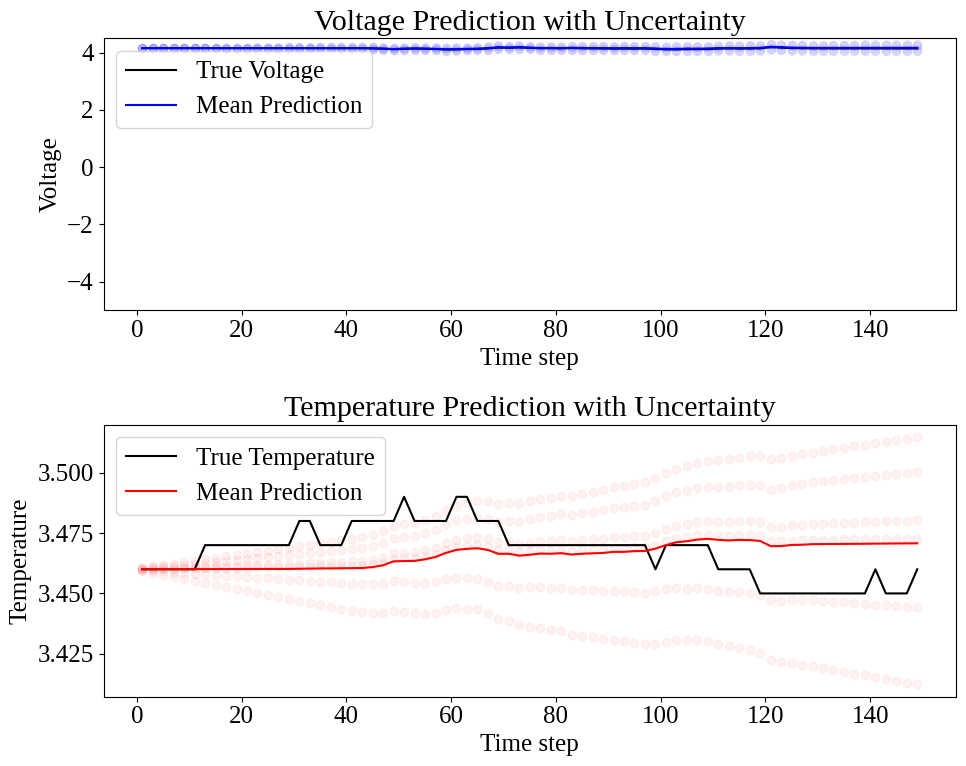

VOLTAGE MAPE  ---> 0.2980345     |||||||||   Temperature MAPE -----------> 0.32198274


In [35]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Example tensors (already on CPU)
preds = tensor_predictions.detach().cpu().numpy()  # [75, 10, 2]
truth = future_states_voltage_temperature.detach().cpu().numpy()  # [75, 2]

timesteps = np.arange(preds.shape[0])*2+1

# Compute mean and std across ensembles
mean_preds = preds.mean(axis=1)      # [75, 2]
std_preds  = preds.std(axis=1)       # [75, 2]
voltage_mape = 100*np.abs((mean_preds[:,0]-truth[:,0])/(truth[:,0]))
voltage_mape = np.mean(voltage_mape)

temperature_mape = 100*np.abs((mean_preds[:,1]-truth[:,1])/(truth[:,1]))
temperature_mape = np.mean(temperature_mape)
# Voltage
plt.figure(figsize=(10,8))
plt.subplot(2, 1, 1)
plt.plot(timesteps, truth[:, 0], 'k-', label="True Voltage")
plt.plot(timesteps, mean_preds[:, 0], 'b-', label="Mean Prediction")
# plt.fill_between(
#     timesteps,
#     mean_preds[:, 0] - 2*std_preds[:, 0],
#     mean_preds[:, 0] + 2*std_preds[:, 0],
#     color='blue', alpha=0.2, label="Uncertainty (±2σ)"
# )

# Heatmap-style intensity = ensemble spread
for i in range(preds.shape[1]):
    plt.scatter(
        timesteps, preds[:, i, 0],
        color='blue', alpha=0.05   # faint points, denser → darker
    )

plt.title("Voltage Prediction with Uncertainty")
plt.xlabel("Time step")
plt.ylabel("Voltage")
plt.ylim(-5, 4.5)   
plt.legend()

# Temperature
plt.subplot(2, 1, 2)
plt.plot(timesteps, truth[:, 1], 'k-', label="True Temperature")
plt.plot(timesteps, mean_preds[:, 1], 'r-', label="Mean Prediction")
# plt.fill_between(
#     timesteps,
#     mean_preds[:, 1] - 2*std_preds[:, 1],
#     mean_preds[:, 1] + 2*std_preds[:, 1],
#     color='red', alpha=0.2, label="Uncertainty (±2σ)"
# )

for i in range(preds.shape[1]):
    plt.scatter(
        timesteps, preds[:, i, 1],
        color='red', alpha=0.05
    )

plt.title("Temperature Prediction with Uncertainty")
plt.xlabel("Time step")
plt.ylabel("Temperature")
plt.legend()

plt.tight_layout()
plt.show()


print("VOLTAGE MAPE  --->", voltage_mape, "    |||||||||   Temperature MAPE ----------->", temperature_mape)


In [36]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Liberation Serif", "DejaVu Serif"]
})
plt.rcParams.update({
    "font.size": 28  # or any size you like
})

def plot_future_currents(future_currents, title=None):
    # convert PyTorch tensor to numpy
    if isinstance(future_currents, torch.Tensor):
        arr = future_currents.detach().cpu().numpy()
    else:
        arr = np.asarray(future_currents)
    #timesteps = np.arange(future_currents.shape[0])*2+1

    # squeeze shape [75,1] → [75]
    if arr.ndim == 2 and arr.shape[1] == 1:
        arr = arr.squeeze(axis=1)

    if title is None:
        title = f"Input Current"

    x = np.arange(future_currents.shape[0])*2#+1
    plt.figure(figsize=(8,4))
    plt.plot(x, arr)  # simple line plot
    plt.xlabel(f"Time Step (s)")
    plt.ylabel("Current (A)")
    # plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    # plt.show()
    plt.savefig("Images_2/Input_Current.pdf")
    plt.close()

plot_future_currents(future_currents)


In [37]:
import torch
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Liberation Serif", "DejaVu Serif"]
})
plt.rcParams.update({
    "font.size": 28  # or any size you like
})

# Example tensors (already on CPU)
preds = tensor_predictions.detach().cpu().numpy()  # [75, 10, 2]
truth = future_states_voltage_temperature.detach().cpu().numpy()  # [75, 2]

timesteps = np.arange(preds.shape[0]) * 2 + 1

# ===========================
# Median across ensembles
# ===========================
median_preds = np.median(preds, axis=1)  # [75, 2]

# Compute MAPE
voltage_mape = 100 * np.abs((median_preds[:, 0] - truth[:, 0]) / truth[:, 0])
voltage_mape = np.mean(voltage_mape)

temperature_mae =  np.abs((median_preds[:, 1] - truth[:, 1]) )
temperature_mae = np.mean(temperature_mae)

# ======================
# Voltage Plot
# ======================
plt.figure(figsize=(8, 5))
plt.plot(timesteps, truth[:, 0], 'k-', label="True Voltage")
plt.plot(timesteps, median_preds[:, 0], 'b-', label="Digital Twin Prediction")

# Ensemble scatter points
# for i in range(preds.shape[1]):
#     if (i==0):
#         plt.scatter(
#             timesteps, preds[:, i, 0],
#             color='blue', alpha=0.2, label = "Voltage predictions from ensemble"
#         )
#     else:
#         plt.scatter(
#             timesteps, preds[:, i, 0],
#             color='blue', alpha=0.2
#         )


# plt.title(f"Voltage Ensemble Prediction \nMAPE: {voltage_mape:.2f} %")
# plt.text(
#     0.5, 0.9,                     # x, y coordinates in axes fraction (0=left/bottom, 1=right/top)
#     f"MAPE: {voltage_mape:.2f} %", 
#     ha='center', va='center',     # center alignment
#     transform=plt.gca().transAxes,  # make coordinates relative to axes (not data)
#     fontsize=18, fontweight='bold', color='black'
# )
plt.xlabel("Time step (s)" )
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.ylim(3.3, 4.5)
plt.legend()

plt.tight_layout()
plt.savefig("Images_2/voltage_predictions_median.pdf")
plt.close()

# ======================
# Temperature Plot
# ======================
plt.figure(figsize=(8, 5))
plt.plot(timesteps, truth[:, 1], 'k-', label="True Temperature")
plt.plot(timesteps, median_preds[:, 1], 'r-', label="Digital Twin Prediction")

# for i in range(preds.shape[1]):
#     if (i==0):
#         plt.scatter(
#             timesteps, preds[:, i, 1],
#             color='red', alpha=0.2, label = "Temperature predictions from ensemble"
#         )
#     else:
#         plt.scatter(
#             timesteps, preds[:, i, 1],
#             color='red', alpha=0.05
#         )

# plt.title(f"Temperature Ensemble Prediction \nMAE: {temperature_mae:.2f} °C")
# plt.text(
#     0.5, 0.9,                     # x, y coordinates in axes fraction (0=left/bottom, 1=right/top)
#     f"MAE: {temperature_mae:.2f} °C", 
#     ha='center', va='center',     # center alignment
#     transform=plt.gca().transAxes,  # make coordinates relative to axes (not data)
#     fontsize=18, fontweight='bold', color='black'
# )
plt.xlabel("Time step (s)")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.ylim(2, 5)
plt.legend()
plt.tight_layout()
plt.savefig("Images_2/temperature_predictions_median.pdf")
plt.close()

# Console printout
print("VOLTAGE MAPE  --->", voltage_mape, "    |||||||||   Temperature MAE ----------->", temperature_mae)


VOLTAGE MAPE  ---> 0.3961011     |||||||||   Temperature MAE -----------> 0.011684481
